In [1]:
import re
import logging
import time

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

from bs4 import BeautifulSoup

import numpy as np
import pandas as pd      

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from gensim.models import Word2Vec

import nltk
# nltk.download()  # Download text data sets, including stop words
from nltk.corpus import stopwords # Import the stop word list

2017-02-23 23:45:08,188 : INFO : 'pattern' package not found; tag filters are not available for English


# Import and preprocess Reviews

In [2]:
print("Review reading...")
# Reading data
file_data = pd.read_csv("reviews_rt_all.csv", sep="|", encoding = 'utf8')
reviews = file_data['text']
print("Reading finished")

Review reading...
Reading finished


# Tokenize Reviews

In [3]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review, "lxml").get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, \
              remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [4]:
%%time
sentences = []  # Initialize an empty list of sentences
print("Parsing sentences from training set")
for i, review in enumerate(reviews):
    sentences += review_to_sentences(review, tokenizer)
    
print("Preprocessing complated")

Parsing sentences from training set


/Users/grycshuknazar/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:219: UserWarning: "." looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
/Users/grycshuknazar/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:219: UserWarning: ".." looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)


Preprocessing complated
CPU times: user 25.7 s, sys: 1.06 s, total: 26.8 s
Wall time: 26.8 s


#  Train model

In [5]:
print(sentences[0])

[u'to', u'an', u'entire', u'generation', u'of', u'filmgoers', u'it', u'just', u'might', u'represent', u'the', u'most', u'significant', u'leap', u'in', u'storytelling', u'that', u'they', u'will', u'ever', u'see']


In [25]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 20    # Minimum word count                        
num_workers = 8       # Number of threads to run in parallel
context = 5          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words
training_algorithm = 1 # 0-CBOW, 1-SkipGram 

In [26]:
%%time
# Initialize and train the model (this will take some time)
print("Training model...")
    
model = Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, \
            sg=training_algorithm)

2017-02-23 23:59:54,501 : INFO : collecting all words and their counts
2017-02-23 23:59:54,502 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-02-23 23:59:54,550 : INFO : PROGRESS: at sentence #10000, processed 158724 words, keeping 16126 word types
2017-02-23 23:59:54,606 : INFO : PROGRESS: at sentence #20000, processed 323380 words, keeping 22920 word types
2017-02-23 23:59:54,653 : INFO : PROGRESS: at sentence #30000, processed 485422 words, keeping 27575 word types
2017-02-23 23:59:54,699 : INFO : PROGRESS: at sentence #40000, processed 644042 words, keeping 31316 word types


Training model...


2017-02-23 23:59:54,750 : INFO : PROGRESS: at sentence #50000, processed 804782 words, keeping 34762 word types
2017-02-23 23:59:54,803 : INFO : PROGRESS: at sentence #60000, processed 967497 words, keeping 38058 word types
2017-02-23 23:59:54,857 : INFO : PROGRESS: at sentence #70000, processed 1134595 words, keeping 41245 word types
2017-02-23 23:59:54,911 : INFO : PROGRESS: at sentence #80000, processed 1302108 words, keeping 43910 word types
2017-02-23 23:59:54,960 : INFO : PROGRESS: at sentence #90000, processed 1468659 words, keeping 46383 word types
2017-02-23 23:59:55,013 : INFO : PROGRESS: at sentence #100000, processed 1637675 words, keeping 48888 word types
2017-02-23 23:59:55,068 : INFO : PROGRESS: at sentence #110000, processed 1813995 words, keeping 51595 word types
2017-02-23 23:59:55,124 : INFO : collected 54210 word types from a corpus of 1986276 raw words and 119525 sentences
2017-02-23 23:59:55,124 : INFO : Loading a fresh vocabulary
2017-02-23 23:59:55,168 : INFO : 

CPU times: user 1min 32s, sys: 566 ms, total: 1min 32s
Wall time: 13.2 s


In [17]:
# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
#model_name = "300features_40minwords_10context"
#model.save(model_name)

In [27]:
# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

2017-02-24 00:00:16,474 : INFO : precomputing L2-norms of word weight vectors


In [28]:
model.most_similar("women")


[(u'men', 0.7483876943588257),
 (u'daughters', 0.7329230308532715),
 (u'individuals', 0.7306944131851196),
 (u'humans', 0.7243083715438843),
 (u'families', 0.718777060508728),
 (u'mothers', 0.717138409614563),
 (u'criminals', 0.7068255543708801),
 (u'souls', 0.6988983154296875),
 (u'misfits', 0.6972213387489319),
 (u'americans', 0.6969531774520874)]

Rendered


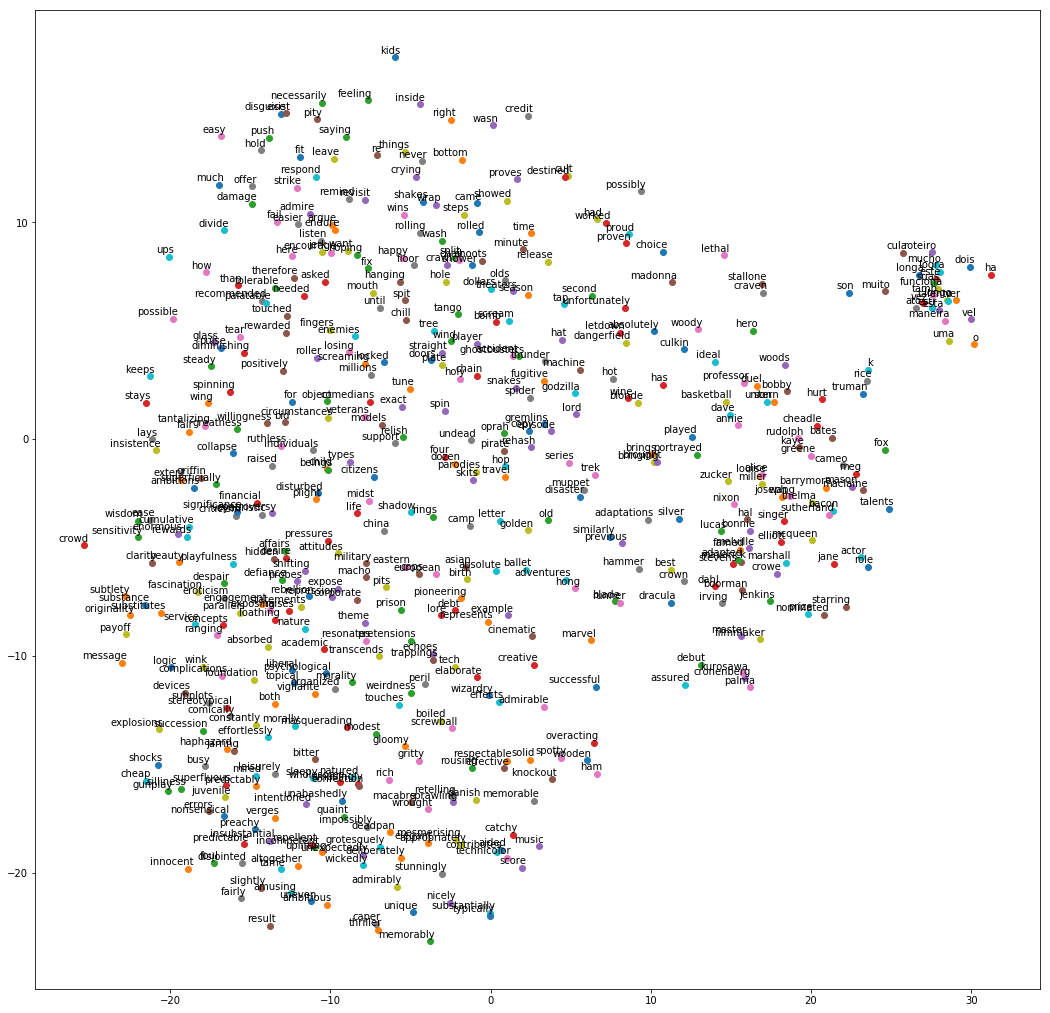

In [29]:
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embs, labels, filename='tsne_skipgram.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)



tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform((model[model.wv.vocab])[:plot_only, :])
labels = [model.wv.vocab.items()[i][0] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)
print("Rendered")